

# Facial Landmarks

In this project: Creation of facial landmarks detector based on CNN regressor.




### Load and preprocess data

 File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints.  
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [0]:
import numpy as np
import pandas as pd

In [0]:
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

file = pd.read_csv('/content/data/gt.csv')
face_points = file[file.columns[1:]]

def load_imgs_and_keypoints(dirname='/content/data'):
    data = pd.read_csv(dirname + '/gt.csv')
    points = np.zeros_like(np.array(data[data.columns[1:]].as_matrix(), dtype=np.float32)
    imgs = np.zeros((N, 100, 100, 3)) 
    pt_tableau = np.array(data[data.columns[1:]].as_matrix(), dtype=np.float32)
    lon = data.shape[0]
    for i in range(lon):
        img = imread(dirname + '/images/' + data.filename[i])
        w = img.shape[1]
        h = img.shape[0]
        points[i,:] = pt_tableau[i,:] / np.tile([w,h], 14) - 0.5
        img = resize(img, (100,100, 3))
        imgs[i,:,:,:] = img
    
    return imgs, points

imgs, points = load_imgs_and_keypoints()

array([-0.3053435 , -0.3053435 , -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480915, -0.30152673, -0.24045801, -0.20610687,
       -0.17557251, -0.21374045, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267175, -0.19847329,  0.23664123, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412213,  0.03435114,
        0.1870229 ,  0.14122137,  0.18320611], dtype=float32)

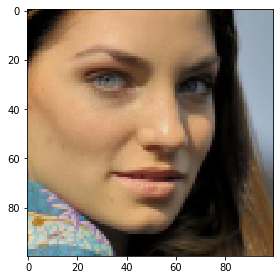

In [0]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

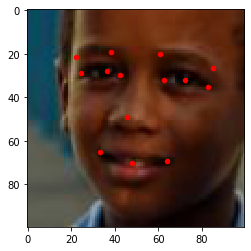

In [0]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_points(img, points):
    fig, ax = plt.subplots()
    im = ax.imshow(img)
    for i in range(len(points)//2):
        plt.plot((points[2*i]+0.5)*100, (points[2*i+1]+0.5)*100, 'o', color='red',markersize=4.5)
    
    plt.show()
    
    pass
    
visualize_points(imgs[1], points[1])

### Train/val split

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Data augmentation

For better training using  simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. 

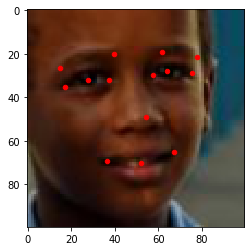

In [0]:
def flip_img(img, points):
    f_img = img[:,::-1,:]
    f_points = np.copy(points)
    for i in range(14):
        f_points[2*i] = -points[2*i]
    return f_img, f_points
    pass

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

In [0]:
N = imgs_train.shape[0]
aug_imgs_train = np.zeros((2*N, 100, 100, 3))
aug_points_train = np.zeros((2*N, 28))
for i in range(N):
    aug_imgs_train[2*i] = imgs_train[i]
    aug_points_train[2*i] = points_train[i]
    f_img, f_points = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train[2*i+1] = f_img
    aug_points_train[2*i+1] = f_points

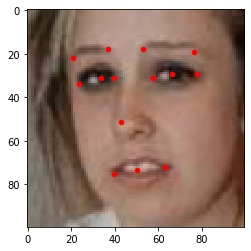

In [0]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

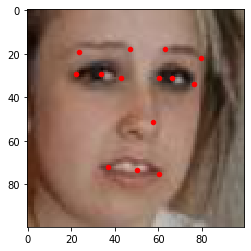

In [0]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training


In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,LeakyReLU,Dropout,Flatten,BatchNormalization
from keras import regularizers
input_img=Input(shape=aug_imgs_train[1].shape)


x=Conv2D(32,(3,3),padding='same',kernel_initializer='he_uniform')(input_img)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)

x=MaxPooling2D((2,2))(x)



x=Conv2D(64,(3,3),padding='same',kernel_initializer='he_uniform')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)

x=MaxPooling2D((2,2))(x)


x=Conv2D(256,(3,3),kernel_initializer='he_uniform')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)

x=MaxPooling2D((2,2))(x)

x=Flatten()(x)

x=Dense(256,name='denseA',kernel_initializer='he_uniform')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)
x=Dropout(0.2)(x)

x=Dense(512,name='denseB',kernel_initializer='he_uniform')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)
x=Dropout(0.3)(x)

regressed=Dense(28,name='output')(x)

regressor=Model(input_img, regressed)

In [0]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import SGD, Adam
EARLYstop=EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
regressor.compile(optimizer=Adam(lr=0.0003,decay=4e-5), loss='mse')
regressor.fit(aug_imgs_train,aug_points_train,epochs=500,batch_size=32,shuffle=True,validation_data=(imgs_val, points_val),callbacks=[checkpoint,e_stop])

Train on 10800 samples, validate on 600 samples
Epoch 1/500
10800/10800 [==============================] - 20s 2ms/step - loss: 0.4408 - val_loss: 0.0591
Epoch 2/500
10800/10800 [==============================] - 18s 2ms/step - loss: 0.1640 - val_loss: 0.0265
Epoch 3/500
10800/10800 [==============================] - 18s 2ms/step - loss: 0.0830 - val_loss: 0.0200
Epoch 4/500
10800/10800 [==============================] - 18s 2ms/step - loss: 0.0555 - val_loss: 0.0185
Epoch 5/500
10800/10800 [==============================] - 18s 2ms/step - loss: 0.0382 - val_loss: 0.0206
Epoch 6/500
10800/10800 [==============================] - 18s 2ms/step - loss: 0.0308 - val_loss: 0.0173
Epoch 7/500
10800/10800 [==============================] - 18s 2ms/step - loss: 0.0270 - val_loss: 0.0175
Epoch 8/500
10800/10800 [==============================] - 18s 2ms/step - loss: 0.0239 - val_loss: 0.0184
Epoch 9/500
10800/10800 [==============================] - 18s 2ms/step - loss: 0.0224 - val_loss: 0.017

### Visualize results

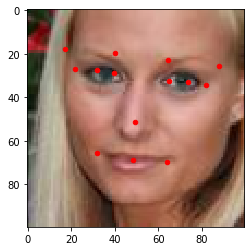

In [0]:
predicted_keypoints=regressor.predict(imgs_val)
visualize_points(imgs_val[1],predicted_keypoints[1]) 

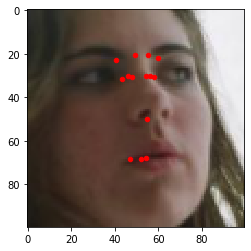

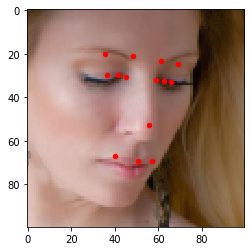

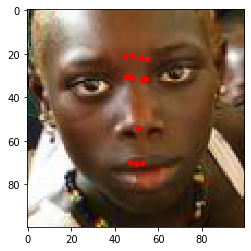

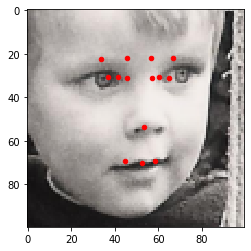

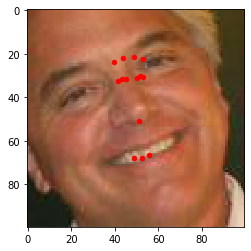

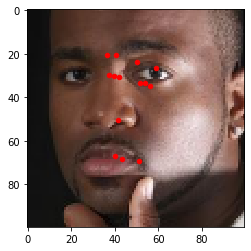

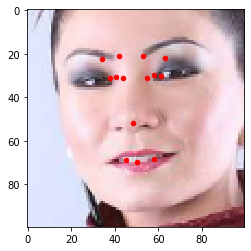

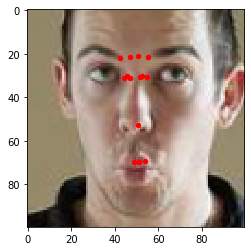

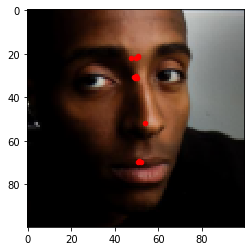

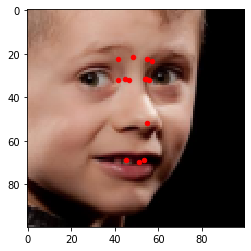

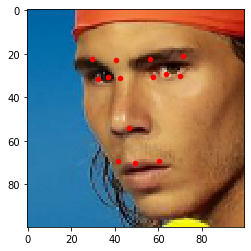

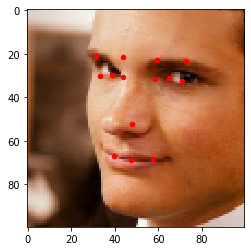

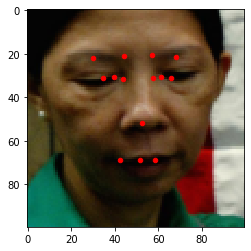

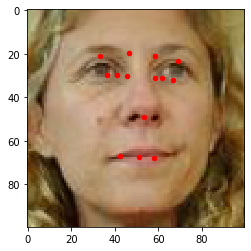

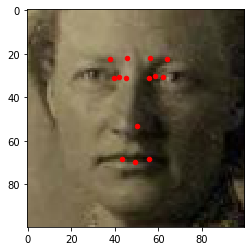

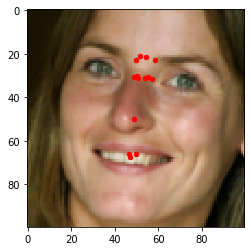

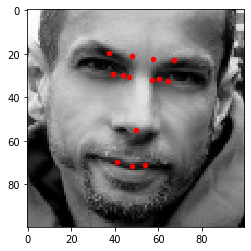

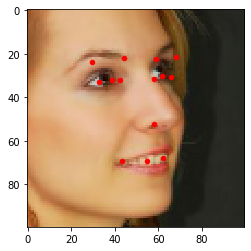

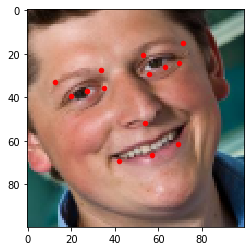

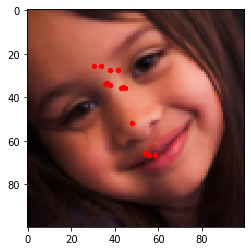

In [0]:
for i in range(20):
    elt=np.random.choice(range(imgs_val.shape[0]))
    visualize_points(imgs_val[elt],predicted_keypoints[elt])